## 4. Tests of Normality
Suppose we have a sample of iid observations $x_1, x_2, . . . , x_N$; we want to test whether these are drawn from a normal distribution. Note the fact that the integer central moments of the normal distribution satisfy 

$Ex=\mu$ 

$E(x-\mu)^m=0$,   $  \ \ \ if m$  odd 

$E(x-\mu)^m=\sigma^m(m-1)$!!  $ \ \ \ if m$ even

where n!! is the double factorial, i.e., $n!!=n(n-2)(n-4)...$
#### 1. Using the analogy principle, construct an estimator for the first $k$ moments of the distribution of $x$. Use this to define a k-vector of moment restrictions $ g_N(\mu, \sigma) $ satisfying $E_{gN}(\mu, \sigma)=0$ under the null hypothesis of normality.

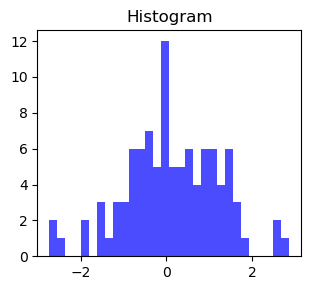

First example
[0.13658958127305948, 0.1708196040607639, -0.1875935159816846, 0.26052374358056873]


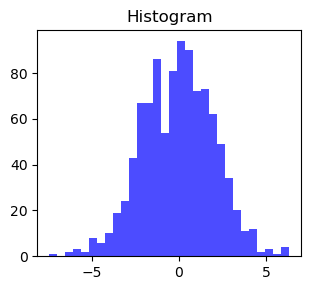

Second example
[-0.023240453660223766, 3.211943079723471, -0.594954535613723, 0.8416878399078414, -27.03689449651105]


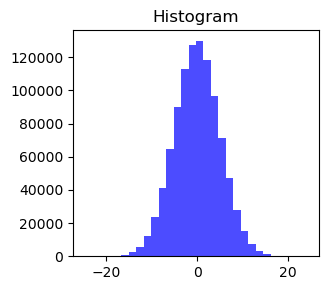

Third example
[-0.012786586974319598, 23.984885763915592, 0.29740558508727755, -0.5702017452153996, 29.244790909209726]


In [118]:
# import numpy as np
from scipy.special import factorial2

def sample_moments(data, k):
    mu_hat = np.mean(data)  # First moment: Mean
    sigma2_hat = np.var(data)  # Second moment: Variance
    moments = [mu_hat, sigma2_hat]
    
    for m in range(3, k+1):  # Start calculating from the third moment
        central_moment = np.mean((data - mu_hat)**m)
        moments.append(central_moment)
    
    return moments

def moment_restrictions(data, k):
    moments = sample_moments(data, k)
    restrictions = [moments[0], moments[1] - 1]  # Check if mean is zero and variance is 1 for normality
    
    for m in range(3, k+1):
        if m % 2 == 1:  # Odd moments should be close to zero for normal distribution
            restrictions.append(moments[m-1])  # Higher odd moments
        else:  # Even moments
            sigma_hat = np.sqrt(moments[1])  # Standard deviation
            theoretical_moment = sigma_hat**m * factorial2(m-1)
            restrictions.append(moments[m-1] - theoretical_moment)    
    return restrictions

def plot_diagnostics(data):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=30, alpha=0.7, color='blue')
    plt.title('Histogram')
    plt.tight_layout()
    plt.show()
    
    
# Example usage
data = np.random.normal(0, 1, 100)  # Sample data from a standard normal distribution
plot_diagnostics(data)
k = 4  # Number of moments to consider
print("First example")
print(moment_restrictions(data, k))


np.random.seed(12)
data = np.random.normal(0, 2, 1000)  # Sample data from a standard normal distribution
plot_diagnostics(data)
k = 5  # Number of moments to consider
print("Second example")
print(moment_restrictions(data, k))


data = np.random.normal(0, 5, 1000000)  # Sample data from a standard normal distribution
plot_diagnostics(data)
k = 5  # Number of moments to consider
print("Third example")
print(moment_restrictions(data, k))


#### 2. What is the covariance matrix of the sample moment restrictions (again under the null)? I.e., what can be said about $Eg_{j}(\mu, \sigma) g_j(\mu, \sigma)^T - Eg_{j}(\mu, \sigma) Eg_j(\mu, \sigma)^T$ ?

 $Eg_{j}(\mu, \sigma) g_j(\mu, \sigma)^T$ --- This term represents the expected value of the outer product of the vector of moment restrictions with itself. This results in a matrix where each element is the expected product of two moment conditions.
 
 $Eg_{j}(\mu, \sigma) Eg_j(\mu, \sigma)^T$ --- Since under the null hypothesis $Eg_j(\mu, \sigma)=0$ (because each is $g_{N}$  is constructed to be zero when the data follow a normal distribution), this term simplifies to a matrix of zeros.

Thus, the expression simplifies to: $Cov[g_{j}(\mu, \sigma)]=Eg_{j}(\mu, \sigma) g_j(\mu, \sigma)^T$ because $Eg_{j}(\mu, \sigma) Eg_j(\mu, \sigma)^T$ is a matrix of zeros.

#### 3. Using your answers to the previous two questions, suggest a GMM-based test of the hypothesis of normality, taking $k > 2$.

The Generalized Method of Moments (GMM) is a statistical method used to estimate parameters of a statistical model. It uses sample moments (averages computed from data) that are known or hypothesized based on the model. In the context of testing normality, we are testing whether the sample data comes from a normal distribution.

Moment restrictions are functions of data that, under the null hypothesis (the data is normally distributed), are expected to equal zero. For a normal distribution, certain properties hold:
* Odd central moments are zero.
* Even central moments are defined by $\sigma^m(m-1)$ where $\sigma$ is the standard deviation of the distribution and $𝑚$ is the moment order.


#### 4. Implement the test you’ve devised using python. You may want to use scipy.stats.distributions.chi2.cdf and scipy.optimize.minimize.


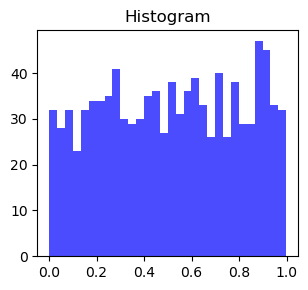

Test statistic: 405.61488580426, p-value: 0.0
Reject the null hypothesis of normality.


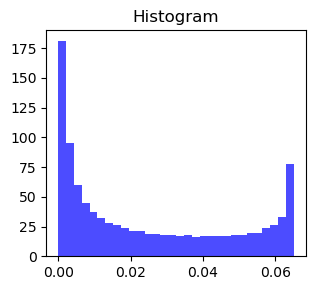

Test statistic: 1224.6202619324486, p-value: 0.0
Reject the null hypothesis of normality.


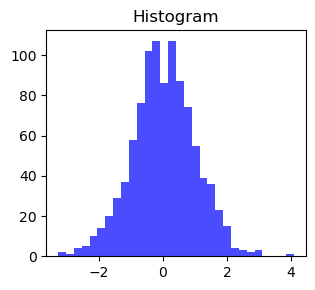

Test statistic: 2.3246643139088556, p-value: 0.31275593376217503
Do not reject the null hypothesis of normality.


In [135]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.special import factorial2

def moment_restrictions(data, params, k):
    mu, sigma = params
    moments = []
    for m in range(1, k+1):
        if m % 2 == 1:  # Odd moments should ideally be zero
            moment = np.mean((data - mu) ** m)
        else:  # Even moments, adjust by theoretical moments
            theoretical_moment = sigma ** m * factorial2(m - 1)
            moment = np.mean((data - mu) ** m) - theoretical_moment
        moments.append(moment)
    return np.array(moments)

def bootstrap_covariance(data, params, k, B=1000):
    bootstrap_samples = np.random.choice(data, (B, len(data)), replace=True)
    moment_samples = np.array([moment_restrictions(sample, params, k) for sample in bootstrap_samples])
    return np.cov(moment_samples, rowvar=False)

def gmm_objective(params, data, cov_inv, k):
    g = moment_restrictions(data, params, k)
    return g.T @ cov_inv @ g

def gmm_test_normality(data, k, initial_params):
    cov_matrix = bootstrap_covariance(data, initial_params, k)
    cov_inv = np.linalg.inv(cov_matrix)
    result = minimize(gmm_objective, initial_params, args=(data, cov_inv, k), method='BFGS')
    
    test_statistic = result.fun
    p_value = 1 - chi2.cdf(test_statistic, df=k-2)
    
    print(f"Test statistic: {test_statistic}, p-value: {p_value}")
    if p_value < 0.05:
        print("Reject the null hypothesis of normality.")
    else:
        print("Do not reject the null hypothesis of normality.")

# Example usage:

data = np.random.uniform(0, 1, size=1000)
k = 4
initial_params = [np.mean(data), np.std(data)]
plot_diagnostics(data)
#plt.title('Random uniform distribution')
gmm_test_normality(data, k, initial_params)


x = np.linspace (0, 40, 1000) 
data = stats.gamma.pdf(x, a=5, scale=3)
k = 4
initial_params = [np.mean(data), np.std(data)]
plot_diagnostics(data)
#plt.title('Gamma distribution')
gmm_test_normality(data, k, initial_params)


data = np.random.normal(0, 1, size=1000)
k = 4
initial_params = [np.mean(data), np.std(data)]
plot_diagnostics(data)
#plt.title('Normal distribution')
gmm_test_normality(data, k, initial_params)



#### 5.  What can be said about the optimal choice of k?

The optimal choice of $𝑘$, the number of moment conditions used in a GMM approach, is crucial and can significantly influence the test's power and size.  
- When the number of moment conditions exceeds the number of parameters being estimated, the model becomes over-identified. 
- Using more moment conditions can potentially make the estimator more efficient because it utilizes more information about the distribution. This is generally true up to a point where the added moments bring in relevant additional information.
- For a normality test, including higher than the second moments is important because the normal distribution is completely characterized by its first two moments (mean and variance). Moments higher than the second (skewness, kurtosis, etc.) can provide crucial information about departures from normality (e.g., asymmetry, tail heaviness).
- As $𝑘$ increases, the moments might become increasingly difficult to estimate accurately, especially for small sample sizes. Moments of higher order are also more sensitive to outliers and can become numerically unstable.

Compare the GMM estimates of $(\mu, \sigma)$ to the maximum likelihood estimates of these parameters. Do they differ? Why

- MLE directly aims to find the parameter values that maximize the likelihood function given the data. For the normal distribution, MLE for $(\mu, \sigma)$ are the sample mean and sample standard deviation, respectively, making it very efficient (in the statistical sense) and unbiased in large samples.
- MLE is known for being asymptotically efficient for many models, including the normal distribution. This means it achieves the lowest possible variance among all unbiased estimators as the sample size grows.
- GMM is based on the method of moments, where parameters are chosen so that the sample moments (often beyond the first two) match their theoretical counterparts as closely as possible. This can be particularly useful when multiple moment conditions are involved, or the distributional assumptions for MLE are not fully justified.
- GMM can be more robust to certain specification errors or when dealing with distributions where MLE is difficult to implement or unreliable due to model complexity or constraints.
- For the normal distribution, if the model is correctly specified and the sample size is large, GMM and MLE for $(\mu, \sigma)$ should be quite similar, especially if the GMM uses the first and second moments as part of its conditions.
- If there are deviations from normality or if additional moments (like skewness and kurtosis) are incorporated into the GMM, the estimates might differ. GMM might then provide an estimate that compensates for these higher-order characteristics, whereas MLE would strictly interpret parameters under the assumption of normality.
- In small samples, MLE can be biased (particularly the estimate for $(\sigma)$, whereas GMM might also suffer from high variability depending on the moments used.


## 5. Logit

This problem is meant to help draw connections between GMM estimators and maximum likelihood estimators, with a particular focus on the ’logit’ model. The development of a maximum likelihood estimator typically begins with an assumption that some random variable has a (conditional) distribution which is known up a k-vector of parameters $\beta$. 
Consider the case in which we observe N independent realizations of a Bernoulli random variable $Y$, with $Pr(Y=1|X)=\sigma(\beta^TX)$ and $Pr(Y=0|X)=1-\sigma(\beta^TX)$

#### 1. Show that under this model $E(Y_i -\sigma(X\beta)|X)=0$. Assume that $\sigma$ is a known function, and use this fact to develop a GMM estimator of $\beta$. Is your estimator just- or over-identified?

Under the Model
In the logistic regression model (logit model), the probability of observing $Y = 1$ given predictors $X$ is modeled as:
${Pr}(Y = 1 | X) = \sigma(\beta^T X)$
where $\sigma$ is the logistic function defined by:
$\sigma(z) = \frac{1}{1 + e^{-z}}$
Conversely, the probability of observing $Y = 0$ given $X$ is:
${Pr}(Y = 0 | X) = 1 - \sigma(\beta^T X)$

Establishing the Expectation
To show that $E(Y_i - \sigma(X\beta) | X) = 0$. To see why this is true, we need to consider the definition of expectation for a Bernoulli random variable $Y$:
$E(Y | X) = 1 \cdot \text{Pr}(Y = 1 | X) + 0 \cdot \text{Pr}(Y = 0 | X) = \sigma(\beta^T X)$

Therefore, the expectation of the difference $Y - \sigma(\beta^T X)$ given $X$ is:

$E(Y - \sigma(\beta^T X) | X) = E(Y | X) - \sigma(\beta^T X) = \sigma(\beta^T X) - \sigma(\beta^T X) = 0$

This shows that the expectation condition holds under the logistic model.

Given the expectation condition $E(Y_i - \sigma(X_i \beta) | X_i) = 0$, we can utilize this as the basis for a GMM estimator. The moment conditions for the GMM are:
$g(\beta, X, Y) = (Y - \sigma(\beta^T X))X$

The GMM estimator will aim to find $\beta$ such that the sample analogue of the expectation of $g(\beta, X, Y)$ is zero:

$\frac{1}{N} \sum_{i=1}^N (Y_i - \sigma(\beta^T X_i)) X_i = 0$

Just- or Over-Identified?

Whether the estimator is just- or over-identified depends on the number of parameters to estimate $\beta$ and the number of moment conditions available.

Just- or Over-Identified?
Whether the estimator is just- or over-identified depends on the number of parameters to estimate $\beta$ and the number of moment conditions available.

- **Just-Identified**: If the number of parameters in $\beta$ is equal to the number of equations (i.e., the dimension of $X$, the system is just-identified. This typically implies that there is exactly one moment condition per parameter to estimate.
- **Over-Identified**: If there are more moment conditions than the number of parameters in $\beta$ (for example, if $X$ includes multiple variables or instruments beyond the number of parameters), the system is over-identified. This can potentially provide a test for the model's validity through the over-identifying restrictions test.

In many practical cases, especially if $X$ is multi-dimensional and $\beta$ includes intercepts or multiple regression coefficients, the system can be just- or over-identified depending on how $X$ and $\beta$ are specified. The GMM estimation approach will use weighting matrices (typically the inverse of the covariance matrix of the moment conditions) to weight the moment conditions and solve for $\beta$.


#### 2. Show that the likelihood can be written as $L(\beta|y,X) = \prod_{i=1}^N\sigma(\beta^T X_i)^{y_i}\left(1-\sigma(\beta^T X_i)\right)^{1-y_i}$

* Model Probabilities

In logistic regression, the probability that $ Y = 1 $ given predictors $ X $ is modeled by the logistic function:
${Pr}(Y = 1 | X) = \sigma(\beta^T X) $

where $ \sigma(z) $ is the logistic function defined as:
$\sigma(z) = \frac{1}{1 + e^{-z}} $

Conversely, the probability that $ Y = 0 $ given $ X $ is the complement:
${Pr}(Y = 0 | X) = 1 - \sigma(\beta^T X) $

* Likelihood Function

The likelihood function for a logistic regression model, given $ N $ independent observations, is the product of the probabilities of observing each data point $ i $ given the parameters $ \beta $. For each observation $ i $, the likelihood contribution depends on whether $ Y_i = 1 $ or $ Y_i = 0 $.

The individual contribution to the likelihood for each data point can be expressed as:
${Pr}(Y_i = y_i | X_i) = \sigma(\beta^T X_i)^{y_i} \left(1 - \sigma(\beta^T X_i)\right)^{1 - y_i} $

where $ y_i $ is the observed value of $ Y $ for observation $ i $ (either 0 or 1).

* Complete Likelihood Function

Given $ N $ independent observations, the complete likelihood function is the product of all individual likelihoods:

$L(\beta | y, X) = \prod_{i=1}^N \sigma(\beta^T X_i)^{y_i} \left(1 - \sigma(\beta^T X_i)\right)^{1 - y_i} $

* Explanation

- The term $ \sigma(\beta^T X_i)^{y_i} $ represents the likelihood of observing $ Y_i = 1 $ if $ y_i = 1 $ and contributes 1 (i.e., no effect) to the product if $ y_i = 0 $.
- The term $ \left(1 - \sigma(\beta^T X_i)\right)^{1 - y_i} $ represents the likelihood of observing $ Y_i = 0 $ if $ y_i = 0 $ and contributes 1 if $ y_i = 1 $.

This formulation reflects the binary nature of the outcome variable $ Y $ and appropriately weights the likelihood contributions depending on the observed values of $ Y $.


#### 3. To obtain the maximum likelihood estimator (MLE) one can chose $b$ to maximize $\log L(b|y,X)$. When the likelihood is well-behaved, the MLE estimator satisfies the first order conditions (also called the "scores'') from this maximization problem, in which case this is called a "type I'' MLE.  Let $\sigma(z)=\frac{1}{1+e^{-z}}$ (this is sometimes called the logistic function, or the sigmoid function), and obtain the scores $S_N(b)$ for this estimation problem.  Show that $E S_N(\beta) = 0$.  Demonstrate that these moment conditions can serve as the basis for a GMM estimator of \(\beta\), and compare this estimator to the GMM estimator you developed above.  Which is more efficient, and why?

* Derivation of Scores for MLE

In the logistic regression context, the log likelihood function $ log L(b|y,X) $ for parameters $ b $ given binary outcomes $ y $ and predictors $ X $ is the natural logarithm of the likelihood function $ L(b|y,X) $. The likelihood function itself was established as:

$ L(b | y, X) = \prod_{i=1}^N \sigma(b^T X_i)^{y_i} \left(1 - \sigma(b^T X_i)\right)^{1 - y_i} $

Thus, the log likelihood becomes:

$ log L(b|y,X) = \sum_{i=1}^N \left[ y_i log \sigma(b^T X_i) + (1 - y_i) log (1 - \sigma(b^T X_i)) \right] $

* Score Function $ S_N(b) $

To obtain the maximum likelihood estimator, we need the gradient (or score) of the log likelihood function with respect to $ b $. The derivative of the log likelihood involves the derivative of the logistic function $ \sigma(z) $, which is:

$ \sigma'(z) = \sigma(z)(1 - \sigma(z)) $

Thus, the derivative of the log likelihood with respect to $ b $ is:

$ \frac{\partial}{\partial b} log L(b|y,X) = \sum_{i=1}^N X_i (y_i - \sigma(b^T X_i)) $

This expression $ \sum_{i=1}^N X_i (y_i - \sigma(b^T X_i)) $ is the score function $ S_N(b) $.

* Expectation $ E[S_N(\beta)] = 0 $

Under the true parameter $ \beta $, the expected value of $ y_i $ given $ X_i $ is $ \sigma(\beta^T X_i) $, and thus:

$ E[y_i - \sigma(\beta^T X_i) | X_i] = \sigma(\beta^T X_i) - \sigma(\beta^T X_i) = 0 $

Given the independence of $ y_i $ from $ y_j $ for $ i \neq j $ given $ X $:

$ E[S_N(\beta)] = E\left[\sum_{i=1}^N X_i (y_i - \sigma(\beta^T X_i))\right] = \sum_{i=1}^N E[X_i (y_i - \sigma(\beta^T X_i))] = 0 $

* Using $ S_N(\beta) $ for GMM Estimation

The score function can serve as the moment conditions for a GMM estimator. The GMM objective would minimize the quadratic form:

$ \min_b \left(S_N(b)^T W S_N(b)\right) $

where $ W $ is a weighting matrix (often the inverse of the covariance matrix of the scores).

* Efficiency Comparison

- **Type I MLE**: The MLE obtained by maximizing the log likelihood is asymptotically efficient under regular conditions due to the information equality (it achieves the Cramer-Rao lower bound).
- **GMM Using $ S_N(b) $**: If the GMM uses the same information as the MLE (i.e., uses the score functions as moments and uses the efficient weighting matrix related to the information matrix), it will be asymptotically equivalent to the MLE in terms of efficiency.
- **GMM Using Other Moments**: If other moments are used (such as those based on higher moments or non-score-based moments), the GMM might be less efficient unless those moments incorporate additional relevant information not captured by the score function.

* Conclusion

The MLE is generally more efficient or at least as efficient as a GMM estimator using the same moments, due to the properties of the likelihood function and the efficient use of information. If the GMM uses different moments that do not align with those from the likelihood approach, it could be less efficient unless it compensates by capturing more comprehensive information about the underlying data generating process.
